In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


Norm stats (0.31651841229383865, 0.3892599391249885)
torch.Size([16, 9, 120, 120])


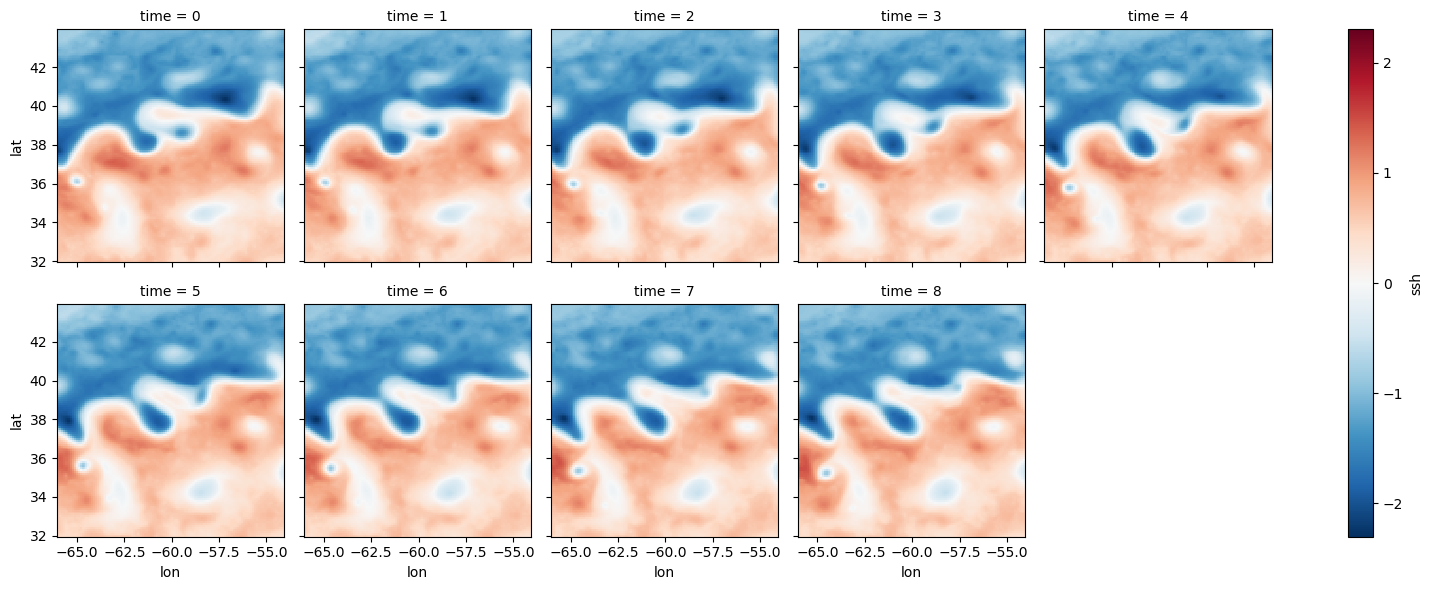

In [2]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *

### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
lat_min = 32
lat_max = 44

datadir="/dmidata/users/maxb/NATL_dataset"
datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 16, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Observational cost and Prior cost

In [3]:
class BaseObsCost(nn.Module):
    def __init__(self, w=1) -> None:
        super().__init__()
        self.w=w

    def forward(self, state, batch):
        msk = batch.input.isfinite()
        return self.w * F.mse_loss(state[msk], batch.input.nan_to_num()[msk])

class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

# Define the solver (classic)

In [6]:
class GradSolver(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, reset_state=True, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None
        self.reset_state = reset_state

    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init

        #return batch.input.nan_to_num().detach().requires_grad_(True)
        return torch.randn(batch.tgt.size(),device=device).detach().requires_grad_(True)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state, batch)
        grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]

        gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )

        return state - state_update

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            if self.reset_state:
                self.grad_mod.reset_state(batch.input)
                
            all_steps = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)
                all_steps.append(state.detach().requires_grad_(True))
                    
            #if not self.training:
            #    state = self.prior_cost.forward_ae(state)
            #state = self.prior_cost.forward_ae(state)
        return state, all_steps


class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.dropout = torch.nn.Dropout(dropout)
        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

In [7]:
device = 'cuda'

# state only
solver = GradSolver(n_step=15,
                    lr_grad=1e-3,
                    prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                    obs_cost = BaseObsCost(),
                    grad_mod = ConvLstmGradModel(dim_in=9,dim_hidden=96)).to(device)#,
                    #grad_mod = GradNet()).to(device)

# Training (disjoint)

In [6]:
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
    
def loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x).to(device)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, y, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

sigma =  25.0#@param {'type':'number'}
#sigma = 5.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Diffusion training

In [9]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

def f_mse(t):
    return np.exp(-t/solver.n_step)

def step_diff(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    # diffusion loss
    eps = 1e-5
    fixed_t = torch.linspace(1-eps, eps, solver.n_step)
    N=15
    random_t = fixed_t[torch.randint(0, solver.n_step, (N,))]
    
    z = torch.randn_like(batch.tgt).to(device)
    std = marginal_prob_std(random_t, sigma=25)
    perturbed_x = (batch.tgt[:,None,:,:,:] + z[:,None,:,:,:] * std[None,:,None,None,None]).requires_grad_(True)
    
    updates = []
    var_cost = []
    for t in range(N):
        updt, vc = solver.solver_step(perturbed_x[:,t,:,:,:], batch, random_t[t])
        updates.append(updt)
        var_cost.append(vc)
        updt = None
        vc = None
    updates = torch.stack(updates,dim=1)
    scores = torch.stack(var_cost,dim=1)
    
    loss_diff = torch.mean(torch.sum((scores * std[None,:, None, None, None] + z[:,None,:,:,:])**2, dim=(2,3,4)))
    
    # mse control loss
    
    #mse_init = torch.mean(F.mse_loss(z, batch.tgt.to(device),reduction="none"),dim=(1,2,3)) 
    #loss_mse = torch.stack([ torch.mean(F.mse_loss(updates[:,t,:,:,:],
    #                                               batch.tgt.to(device),reduction="none"),
    #                                    dim=(1,2,3)) - mse_init*f_mse(t)  for t in range(len(fixed_t)) ],
    #                       dim=1)
    #loss_mse = torch.mean(loss_mse)
    denoised_x = torch.cat((perturbed_x[:,1:,:,:,:],torch.unsqueeze(batch.tgt,dim=1)),dim=1)
    loss_mse = F.mse_loss(updates, denoised_x)
    
    #loss = loss_diff + 10000*loss_mse
    #print(loss_diff)
    #print(loss_mse)
    loss = 100*loss_mse
                
    return loss

# Classic training

In [8]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out, all_steps = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out, all_steps

def base_step(batch):

    out, all_steps = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out, all_steps
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [10]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  1000#@param {'type':'integer'}
lr = 1e-4 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])

reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_4diff.pth', map_location=device)
    solver.load_state_dict(ckpt)

tqdm_epoch = tqdm(range(n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).to(device))
    #loss = step_diff(batch)
    loss, out, all_steps = step(batch)
    all_steps = torch.stack(all_steps,dim=1)
    optimizer.zero_grad()
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
    loss = None
    clear_output(wait=True)
    
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5)) 
  gt = ax1.imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(gt, ax=ax1)
  inp = ax2.imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(inp, ax=ax2)
  inp = ax3.imshow(out[0,4,:,:].detach().cpu(),aspect='auto') 
  plt.colorbar(inp, ax=ax3)
  plt.show()
  xr.Dataset(data_vars={'ssh':(('steps','lat','lon'),all_steps[0,:,4,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='steps',col_wrap=5)
  plt.show()
  """ 
  # sampling
  state = torch.randn_like(batch.tgt).to(device) * marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None] 
  state = state.requires_grad_(True)
  for step in range(solver.n_step):
    state, _ = solver.solver_step(state, batch, step=step)
  #out = solver(batch)
  inp = ax3.imshow(state[0,4,:,:].detach().cpu(),aspect='auto') 
  plt.colorbar(inp, ax=ax3)
  plt.show()
  """
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_4diff.pth')

tensor(0.5099, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(6.1967, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.1538, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

# Test of the model

tensor(0.8637, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(9.4151, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.1766, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8822, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(9.5612, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.1770, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8797, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(9.5365, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.1766, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8631, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(9.3766, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.1762, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8691, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(9.4877, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor

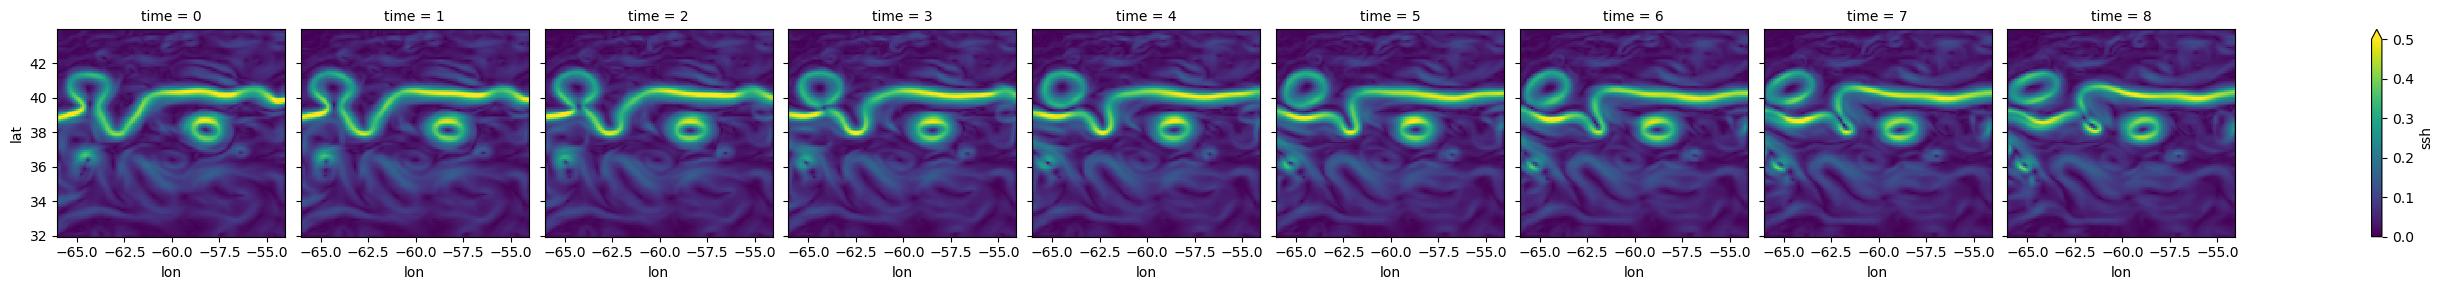

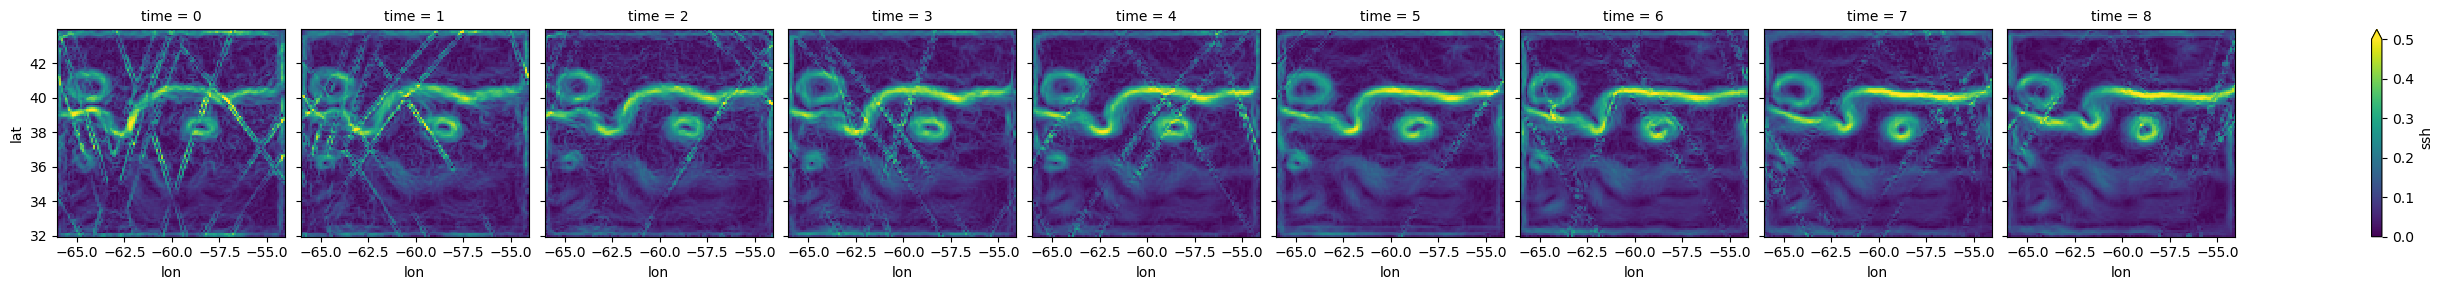

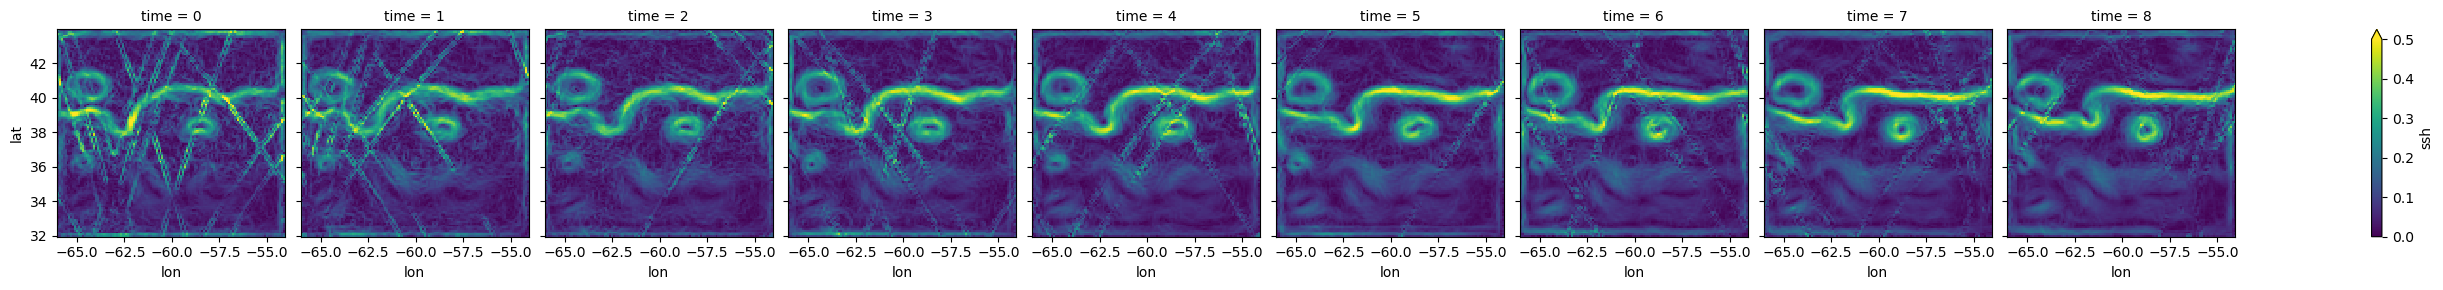

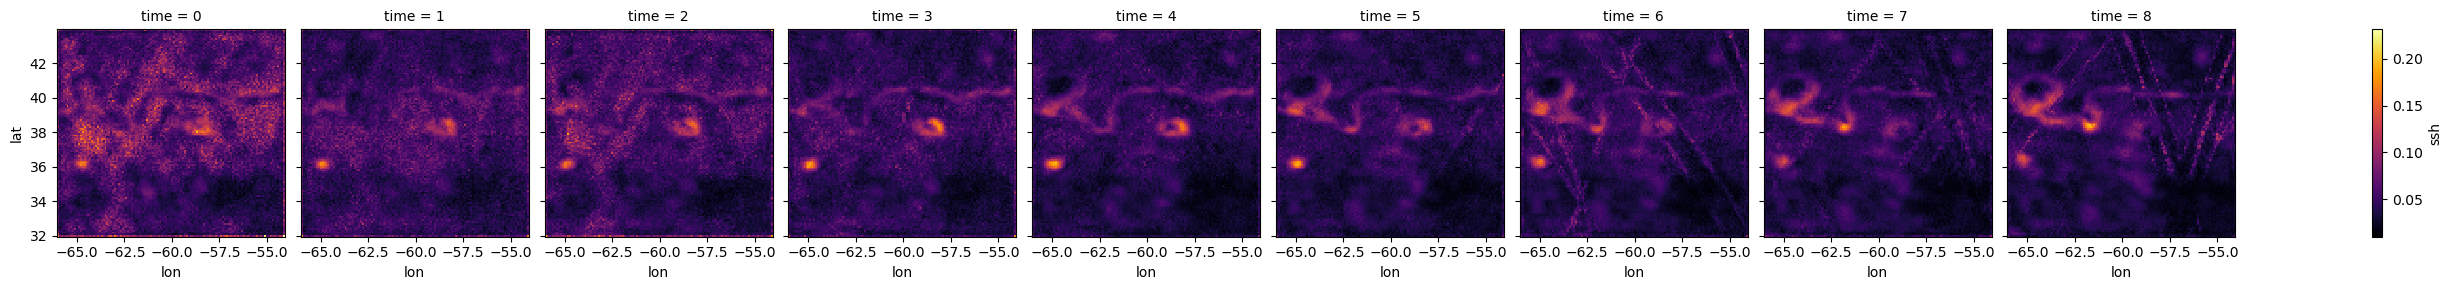

In [11]:
# test
from IPython.display import clear_output
#ckpt = torch.load('../ckpt/ckpt_4diff.pth', map_location=device)
#solver.load_state_dict(ckpt)

from kornia.filters import sobel

k = 1
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))
test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

def sample(batch):
    state = torch.randn_like(batch.tgt).to(device) * marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None] 
    state = state.requires_grad_(True)
    for step in range(solver.n_step):
        state, _ = solver.solver_step(state, batch, step=step)
    return state

def sample(batch):
    loss, out, all_steps = step(batch)
    return out.detach().cpu()

out = []
for i in range(20):
    out.append(sample(test_batch))

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(test_batch.tgt)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(out[0])[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(out[1])[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',cmap=plt.cm.inferno)

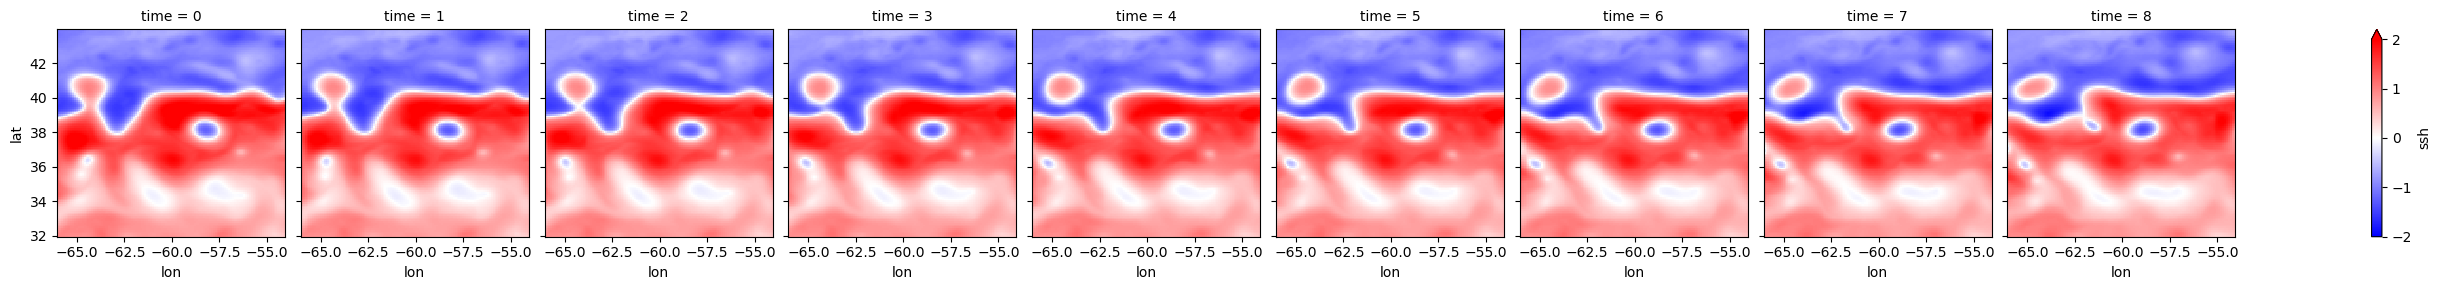

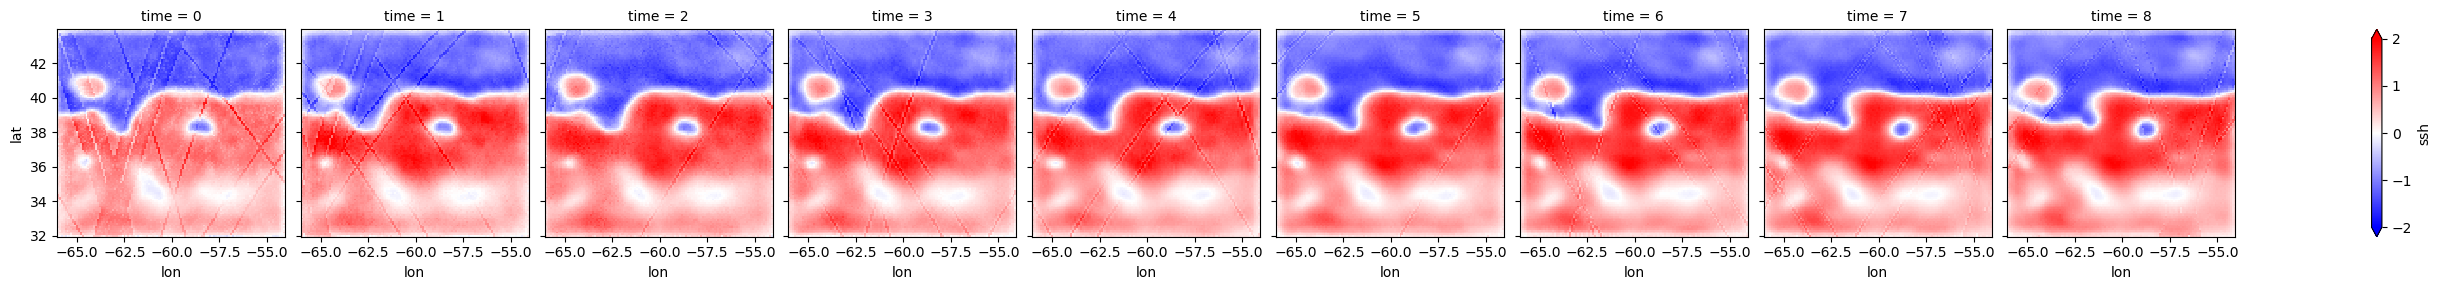

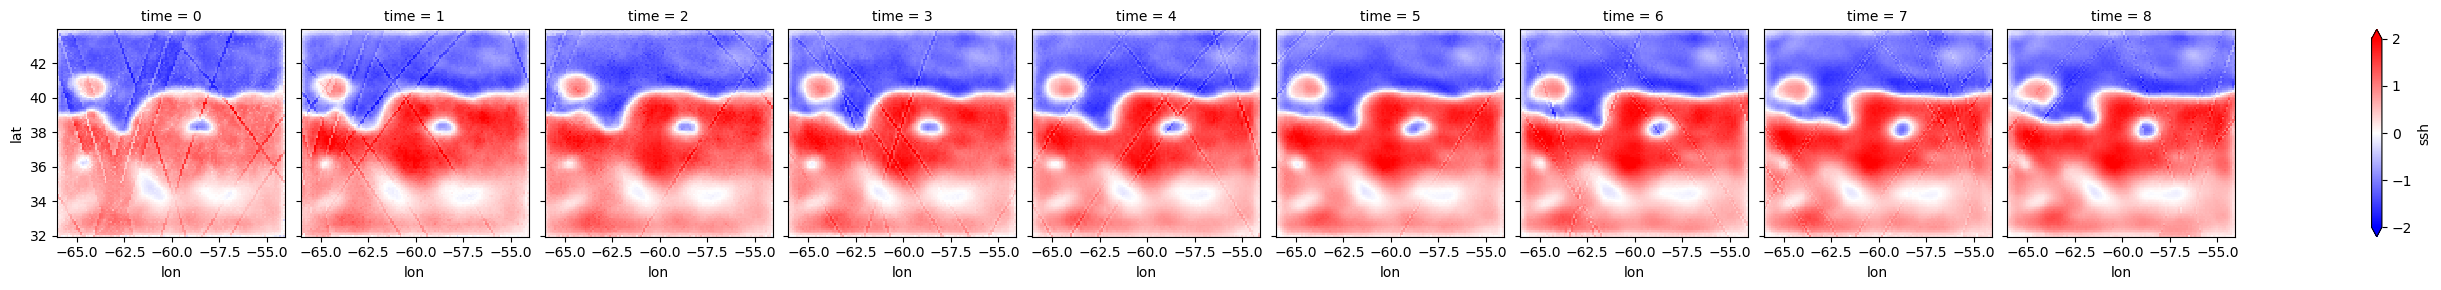

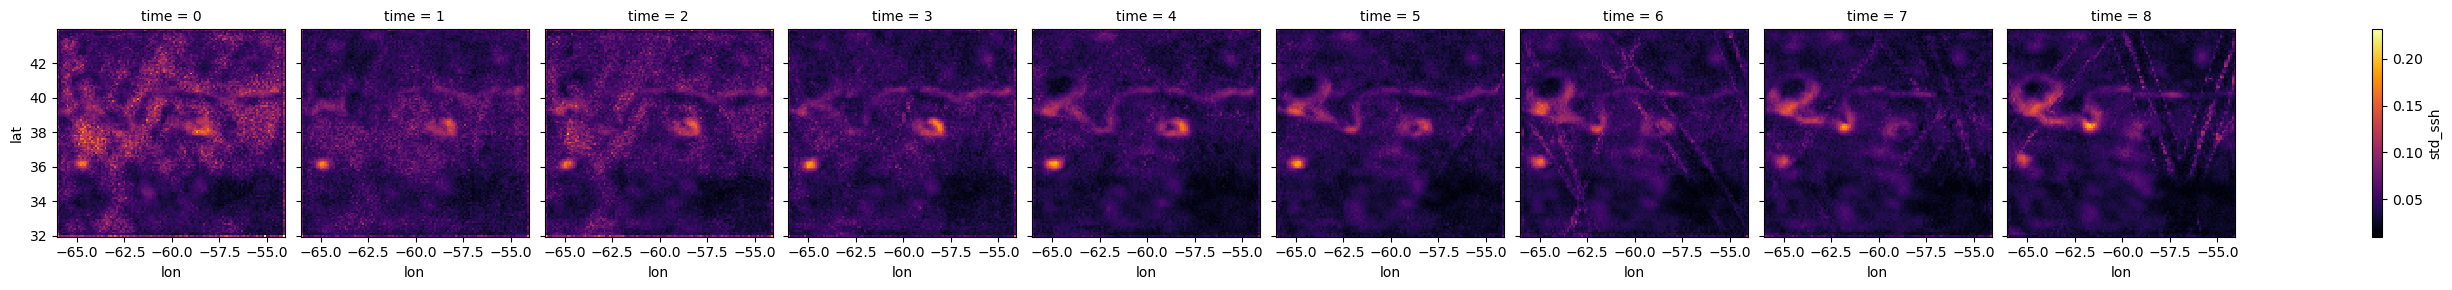

In [12]:
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0][0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[1][0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'std_ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).std_ssh.plot(col='time',cmap=plt.cm.inferno)